In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from scipy.stats import kstest
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL

# Load the ETH dataset

In [2]:
df = pd.read_csv('dataset.csv', header=None)

df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (ETH)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Ignore']

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412 entries, 0 to 1411
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Open Time                  1412 non-null   int64  
 1   Open                       1412 non-null   float64
 2   High                       1412 non-null   float64
 3   Low                        1412 non-null   float64
 4   Close                      1412 non-null   float64
 5   Volume (ETH)               1412 non-null   float64
 6   Close Time                 1412 non-null   int64  
 7   Quote Asset Volume (USDT)  1412 non-null   float64
 8   No. of trades              1412 non-null   int64  
 9   Buy Base Volume (ETH)      1412 non-null   float64
 10  Buy Quote Volume (USDT)    1412 non-null   float64
 11  Ignore                     1412 non-null   float64
dtypes: float64(9), int64(3)
memory usage: 132.5 KB


In [4]:
df.head()

,Open Time,Open,High,Low,Close,Volume (ETH),Close Time,Quote Asset Volume (USDT),No. of trades,Buy Base Volume (ETH),Buy Quote Volume (USDT),Ignore
0,1502928000000,301.13,312.18,298.00,302.00,7030.71034,1503014399999,2.154655e+06,4522,6224.58999,1.908705e+06,50579.872288
1,1503014400000,302.00,311.79,283.94,293.96,9537.84646,1503100799999,2.858947e+06,5658,7452.43542,2.240813e+06,55329.574324
2,1503100800000,293.31,299.90,278.00,290.91,2146.19773,1503187199999,6.200226e+05,1795,1537.97550,4.447136e+05,58005.171046
3,1503187200000,289.41,300.53,282.85,299.10,2510.13871,1503273599999,7.428479e+05,2038,2186.68739,6.475061e+05,60299.066154
4,1503273600000,299.10,346.52,294.60,323.29,5219.44542,1503359999999,1.689472e+06,3925,4004.19967,1.297977e+06,66203.840222


# Preprocessing
#### The 'Open Time' and 'Close Time' columns are recorded in Unix Epoch Time so I will convert this into Standard Local Time for clarity.

In [5]:
df['Open Date'] = pd.to_datetime(df['Open Time'], unit='ms')

In [6]:
df

,Open Time,Open,High,Low,Close,Volume (ETH),Close Time,Quote Asset Volume (USDT),No. of trades,Buy Base Volume (ETH),Buy Quote Volume (USDT),Ignore,Open Date
0,1502928000000,301.13,312.18,298.00,302.00,7030.71034,1503014399999,2.154655e+06,4522,6224.58999,1.908705e+06,50579.872288,2017-08-17
1,1503014400000,302.00,311.79,283.94,293.96,9537.84646,1503100799999,2.858947e+06,5658,7452.43542,2.240813e+06,55329.574324,2017-08-18
2,1503100800000,293.31,299.90,278.00,290.91,2146.19773,1503187199999,6.200226e+05,1795,1537.97550,4.447136e+05,58005.171046,2017-08-19
3,1503187200000,289.41,300.53,282.85,299.10,2510.13871,1503273599999,7.428479e+05,2038,2186.68739,6.475061e+05,60299.066154,2017-08-20
4,1503273600000,299.10,346.52,294.60,323.29,5219.44542,1503359999999,1.689472e+06,3925,4004.19967,1.297977e+06,66203.840222,2017-08-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,1624492800000,1967.95,2036.61,1884.79,1989.52,701231.67478,1624579199999,1.377800e+09,833337,344155.41659,6.763048e+08,0.000000,2021-06-24
1408,1624579200000,1989.53,2019.99,1791.22,1808.82,858808.54767,1624665599999,1.612557e+09,1041338,408120.68053,7.665949e+08,0.000000,2021-06-25
1409,1624665600000,1808.97,1852.80,1717.32,1829.64,832315.14904,1624751999999,1.478551e+09,923226,407180.66965,7.233913e+08,0.000000,2021-06-26
1410,1624752000000,1829.84,1984.50,1804.26,1982.28,696055.79307,1624838399999,1.299522e+09,1091206,354611.53419,6.628817e+08,0.000000,2021-06-27


#### The Open Time is the time of the price at the very start of the day which would be midnight. The Close Time is the time of the price at the very end of the day which would be JUST before midnight.
#### The reason why only the date appears in the Open Time column is because each date in this column shows midnight which is redundant information for me. I only need the date.
#### I will just display some examples of the times here once for confirmation:

In [7]:
# The first 3 values in the 'Open Time' column

print(pd.to_datetime(1502928000000, unit='ms'))
print(pd.to_datetime(1503014400000, unit='ms'))
print(pd.to_datetime(1503100800000, unit='ms'))


2017-08-17 00:00:00
2017-08-18 00:00:00
2017-08-19 00:00:00


#### As we can see, the times are all midnight so this information is not displayed
#### I will repeat the conversion to local time for the Close Times column

In [8]:
df['Close Date'] = pd.to_datetime(df['Close Time'], unit='ms')

In [9]:
df

,Open Time,Open,High,Low,Close,Volume (ETH),Close Time,Quote Asset Volume (USDT),No. of trades,Buy Base Volume (ETH),Buy Quote Volume (USDT),Ignore,Open Date,Close Date
0,1502928000000,301.13,312.18,298.00,302.00,7030.71034,1503014399999,2.154655e+06,4522,6224.58999,1.908705e+06,50579.872288,2017-08-17,2017-08-17 23:59:59.999
1,1503014400000,302.00,311.79,283.94,293.96,9537.84646,1503100799999,2.858947e+06,5658,7452.43542,2.240813e+06,55329.574324,2017-08-18,2017-08-18 23:59:59.999
2,1503100800000,293.31,299.90,278.00,290.91,2146.19773,1503187199999,6.200226e+05,1795,1537.97550,4.447136e+05,58005.171046,2017-08-19,2017-08-19 23:59:59.999
3,1503187200000,289.41,300.53,282.85,299.10,2510.13871,1503273599999,7.428479e+05,2038,2186.68739,6.475061e+05,60299.066154,2017-08-20,2017-08-20 23:59:59.999
4,1503273600000,299.10,346.52,294.60,323.29,5219.44542,1503359999999,1.689472e+06,3925,4004.19967,1.297977e+06,66203.840222,2017-08-21,2017-08-21 23:59:59.999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,1624492800000,1967.95,2036.61,1884.79,1989.52,701231.67478,1624579199999,1.377800e+09,833337,344155.41659,6.763048e+08,0.000000,2021-06-24,2021-06-24 23:59:59.999
1408,1624579200000,1989.53,2019.99,1791.22,1808.82,858808.54767,1624665599999,1.612557e+09,1041338,408120.68053,7.665949e+08,0.000000,2021-06-25,2021-06-25 23:59:59.999
1409,1624665600000,1808.97,1852.80,1717.32,1829.64,832315.14904,1624751999999,1.478551e+09,923226,407180.66965,7.233913e+08,0.000000,2021-06-26,2021-06-26 23:59:59.999
1410,1624752000000,1829.84,1984.50,1804.26,1982.28,696055.79307,1624838399999,1.299522e+09,1091206,354611.53419,6.628817e+08,0.000000,2021-06-27,2021-06-27 23:59:59.999


#### In the Close Date column, the times are displayed because they are not midnight. However, the times are the same for each entry in this column so it is not useful to me and I would like to remove it. I will use the datatime normalise function to do this.

In [10]:
df['Close Date'] = df['Close Date'].dt.normalize()

#### I will remove the original Open Time and Close Time columns as I no longer need these. 

In [11]:
df.drop(['Open Time', 'Close Time'], axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412 entries, 0 to 1411
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Open                       1412 non-null   float64       
 1   High                       1412 non-null   float64       
 2   Low                        1412 non-null   float64       
 3   Close                      1412 non-null   float64       
 4   Volume (ETH)               1412 non-null   float64       
 5   Quote Asset Volume (USDT)  1412 non-null   float64       
 6   No. of trades              1412 non-null   int64         
 7   Buy Base Volume (ETH)      1412 non-null   float64       
 8   Buy Quote Volume (USDT)    1412 non-null   float64       
 9   Ignore                     1412 non-null   float64       
 10  Open Date                  1412 non-null   datetime64[ns]
 11  Close Date                 1412 non-null   datetime64[ns]
dtypes: dat

#### I will remove some of the features that aren't necessary for calculations within technical indicators or algorithms used to predict future prices.

In [13]:
df.drop(['Ignore', 'Volume (ETH)', 'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [14]:
df.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412 entries, 0 to 1411
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Open        1412 non-null   float64       
 1   High        1412 non-null   float64       
 2   Low         1412 non-null   float64       
 3   Close       1412 non-null   float64       
 4   Volume      1412 non-null   float64       
 5   Close Date  1412 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 66.3 KB


### The columns that I currently have in the dataset are the following:

- Open : The price of ETH at the very start of the day (at 24:00) in terms of USDT (which is a crytocurrency that can be exchanged 1:1 with the US Dollar)
- High : The highest ETH price that was reached on this particular day in terms of USDT
- Low : The lowest ETH price that was reached on this particular day in terms of USDT
- Close : The price of ETH at the very end of the day (at 23:59) in terms of USDT
- Volume : The total volume for the day in terms of USDT 
- Close Date : The date that the prices were taken from.

### I will confirm that there are no null values in the dataset by creating a heatmap

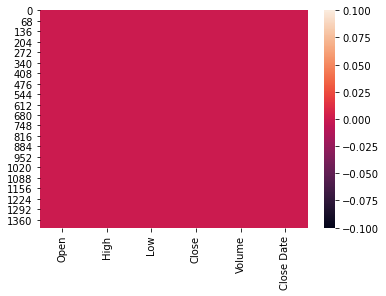

In [16]:
sns.heatmap(df.isnull()) 

# Data Visualisation 

### I will create some plots to help visualise the dataset

### Correlation matrix to visualise the correlation between the different features in the dataset

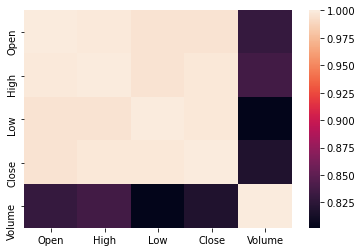

In [17]:
correlation = df.corr()
sns.heatmap(correlation) 

#### I can see here that there is quite a lot of correlation between the features, except of course the features that have different units (ETH and USDT). 

### I will plot some of the price and volume data to look at the trend of the data

[Text(0, 0.5, 'Close Price'),
 (17357.0, 18838.0),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'ETH Price')]

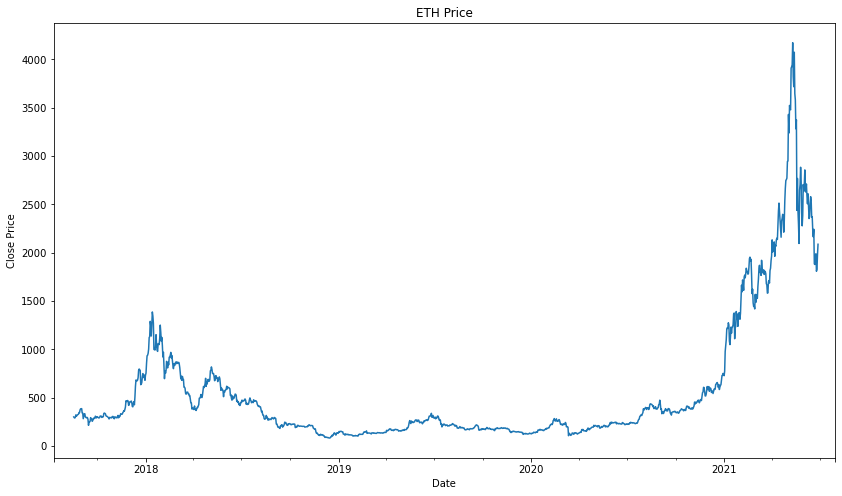

In [18]:
plt.figure(figsize=(14,8)) 
ax = df.groupby(['Close Date'])['Close'].mean().plot()
ax.set(xlabel="Date",
       ylabel="Close Price",
       title="ETH Price",
       xlim=["2017-07-10", "2021-07-30"])

[Text(0, 0.5, 'Volume'),
 (17357.0, 18838.0),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Trading Volume for ETH')]

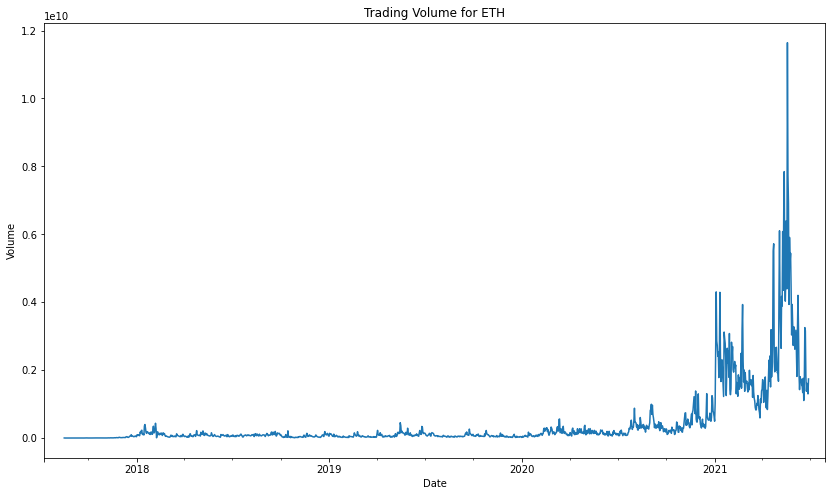

In [19]:
plt.figure(figsize=(14,8)) 
ax = df.groupby(['Close Date'])['Volume'].mean().plot()
ax.set(xlabel="Date",
       ylabel="Volume",
       title="Trading Volume for ETH",
       xlim=["2017-07-10", "2021-07-30"])

<ipython-input-20-e111f8750007>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Year'] = pd.DatetimeIndex(subset['Close Date']).year


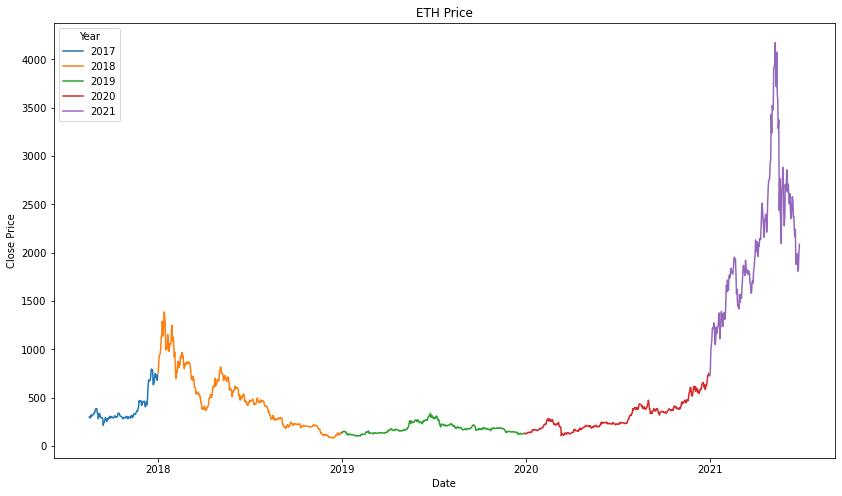

In [20]:
subset = df[['Close', 'Close Date']]
subset['Year'] = pd.DatetimeIndex(subset['Close Date']).year

fig, ax = plt.subplots(figsize=(14,8))

years = mdates.YearLocator()
ax.xaxis.set_major_locator(years)
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(yearsFmt)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ETH Price')
sns.lineplot(data=subset, x='Close Date', y='Close', hue='Year', palette='tab10')

I can visualise the distribution of the with a histogram and a boxplot

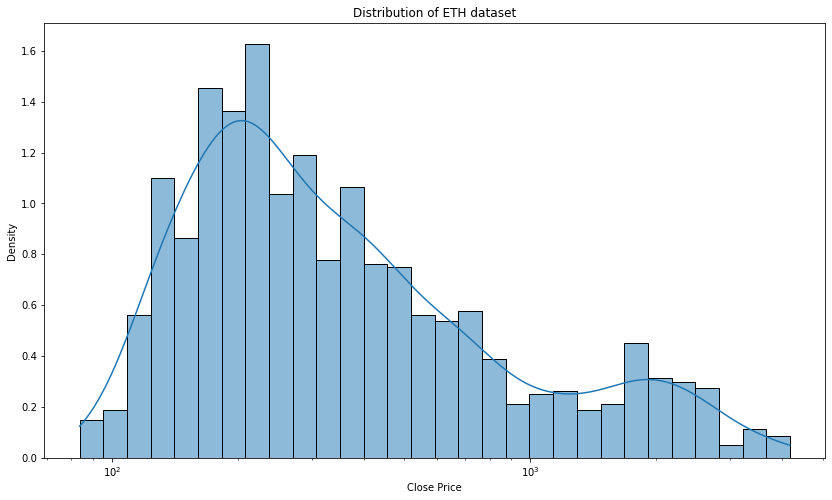

In [21]:
plt.figure(figsize=(14,8))
plt.xlabel('Close Price')
plt.title('Distribution of ETH dataset')
sns.histplot(data=df, x="Close", bins=30, log_scale=True, kde=True, stat='density')

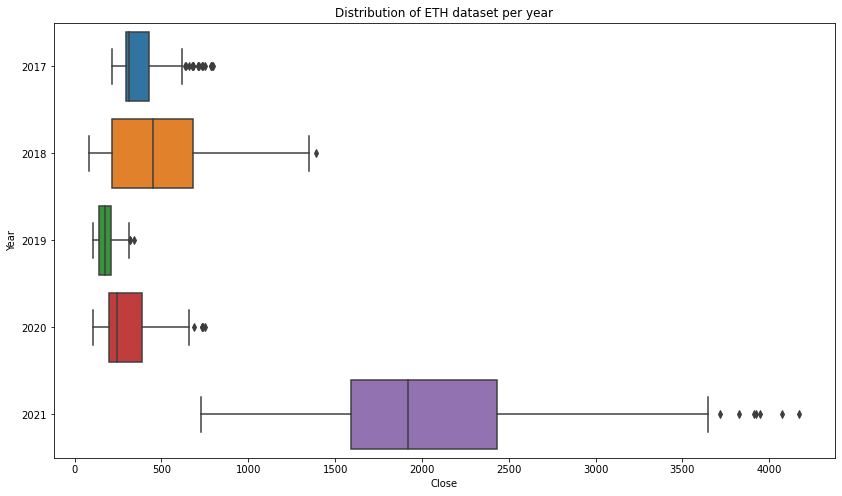

In [22]:
fig, ax = plt.subplots(figsize=(14,8))
plt.xlabel('Close Price')
plt.title('Distribution of ETH dataset per year')
sns.boxplot(x = subset['Close'], y = subset['Year'], ax=ax, orient='h')

From the two graphs above it looks like the dataset is not normally distributed. For quantitative support, I can use the Kolmogorov-Smirnov test for normality

In [23]:
t_stat, p = kstest(df['Close'], 'norm')
print('t-statistic = %.3f , p-value = %.3f' % (t_stat, p))

t-statistic = 1.000 , p-value = 0.000


#### p< 0.05 therefore the data is drawn from a non-normal distribution

A lag plot can show if a dataset contains random values or not and also the correlation between data points

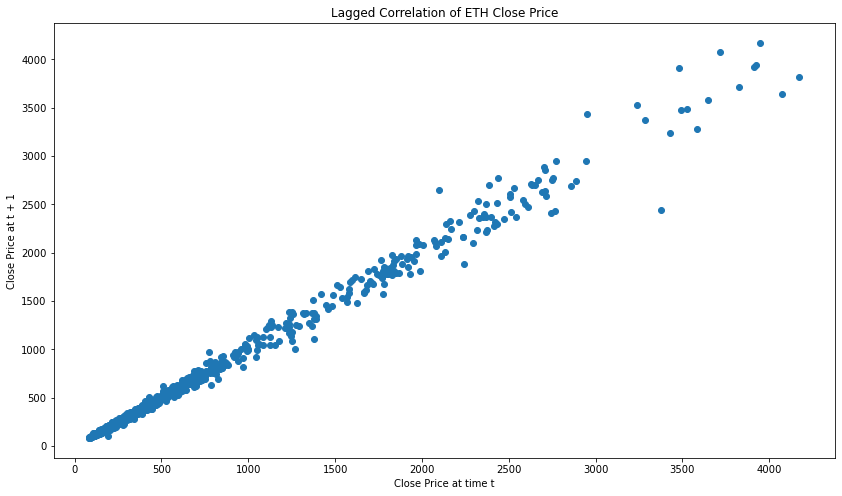

In [24]:
prices = df['Close']
ser = pd.Series(prices)
plt.figure(figsize=(14,8))
pd.plotting.lag_plot(ser, lag= 1)
plt.xlabel('Close Price at time t')
plt.ylabel('Close Price at t + 1')
plt.title('Lagged Correlation of ETH Close Price')
plt.show()

#### Shows moderate autocorrelation

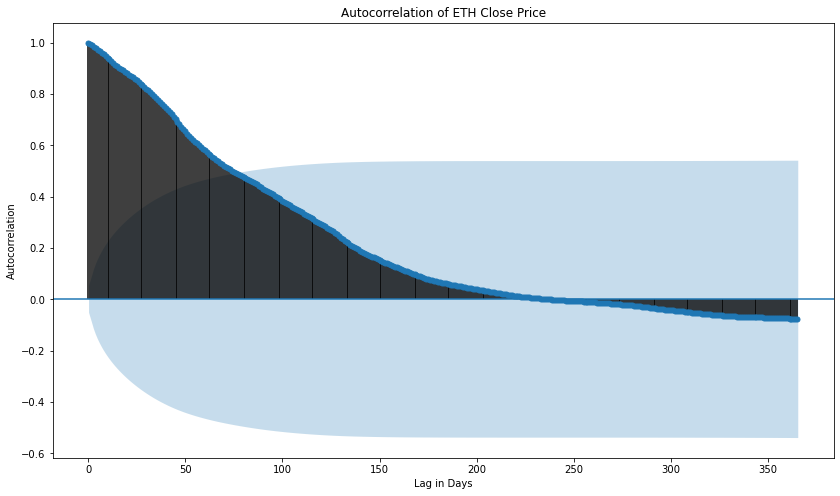

In [25]:
df.set_index('Close Date', inplace=True)
plt.rc("figure", figsize=(14,8))
sm.graphics.tsa.plot_acf(df['Close'].values, lags=365)
plt.xlabel('Lag in Days')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of ETH Close Price')
plt.show()

#### strong autocorrelation, gradually reducing. Not very noisy. Very good prediction capabilities when modelled. (https://www.itl.nist.gov/div898/handbook/eda/section3/autocop3.htm)

### Decompose to visualise trend and seasonality

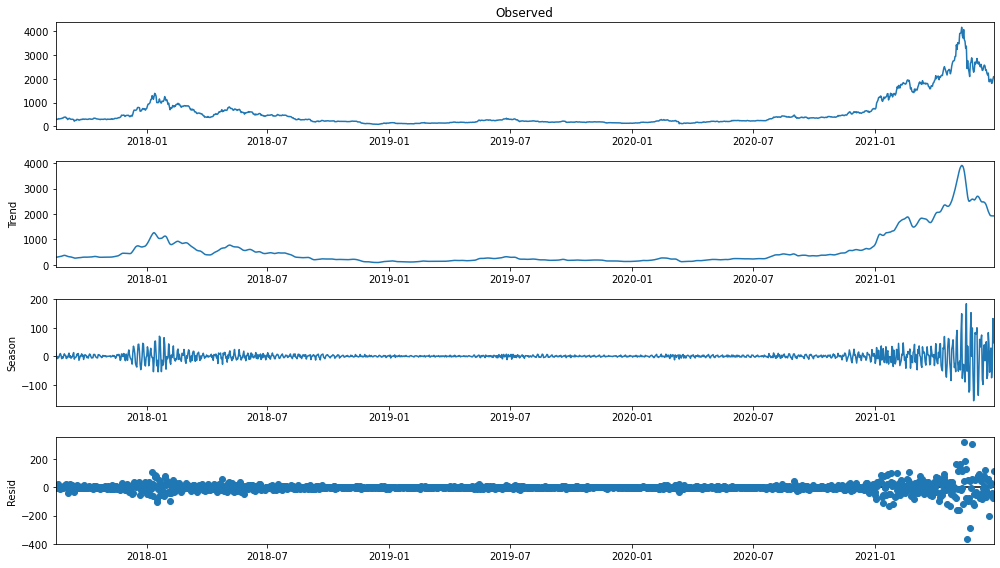

In [26]:
subset1 = subset.set_index('Close Date')
subset1.drop(['Year'], axis=1, inplace = True)

decomp = STL(subset1).fit()
decomp.plot()
plt.show()

Based on the ACF plot it seems like the time series is non-stationary. It also seems that the timeseries has a non-constant variance.

To quantitatively confirm the non-stationarity of the time series, I will carry out an Augmented Dickey-Fuller test and KPSS test. (https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [27]:
def adf_test(timeseries):
    print ('Dickey-Fuller Test Results:')
    adftest = adfuller(timeseries, autolag='AIC')
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    print (adfoutput)

In [28]:
adf_test(df['Close'])

Dickey-Fuller Test Results:
Test Statistic                   -0.245160
p-value                           0.932920
#Lags Used                       24.000000
Number of Observations Used    1387.000000
Critical Value (1%)              -3.435073
Critical Value (5%)              -2.863626
Critical Value (10%)             -2.567881
dtype: float64


p>0.05 and t-statistic is below all the critical values therefore accept null hypothesis. TIme series has a unit root and is NON-stationary. (https://machinelearningmastery.com/time-series-data-stationary-python/)

In [29]:
def kpss_test(timeseries):
    print ('KPSS Test Results:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output) 

In [30]:
kpss_test(df['Close']) 

KPSS Test Results:
Test Statistic            1.587103
p-value                   0.010000
Lags Used                24.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\zara2\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


p<0.05 and t-statistic is above all the critical values therefore reject null hypothesis. Time series has a unit root and is NON-stationary.

# Split dataset

#### I will now split the timeseries into training and test sets, before I scale it to prevent data leakage. https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/
#### I'll be splitting the data into three sets (Training, Validation and Test)  as per the holdout method to help with determining the generalisation ability of the model during model selection. 
#### 61.45% of the data will be used for training, 12.7% will be used as the validation set and the remaining 25.85% will be used as the test set

In [31]:
df.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-08-17,301.13,312.18,298.00,302.00,2.154655e+06
2017-08-18,302.00,311.79,283.94,293.96,2.858947e+06
2017-08-19,293.31,299.90,278.00,290.91,6.200226e+05
2017-08-20,289.41,300.53,282.85,299.10,7.428479e+05
2017-08-21,299.10,346.52,294.60,323.29,1.689472e+06


In [32]:
columns = df.columns.tolist()                  # want to change the order of columns so splitting into X and y will be easier
columns = columns[-1:] + columns[:-1]
df = df[columns]
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29


In [33]:
split = int(len(df)*0.6145)
trainset = df[:split]
subset = df[split:]

split2 = int(len(subset)*0.3303)
valset = subset[:split2]
testset = subset[split2:]

In [34]:
trainset

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29
...,...,...,...,...,...
2019-12-27,3.002010e+07,125.58,127.10,121.91,126.29
2019-12-28,2.517712e+07,126.28,129.68,125.84,128.11
2019-12-29,4.189308e+07,128.11,138.07,127.52,134.36


In [35]:
valset

,Volume,Open,High,Low,Close
Close Date,,,,,
2020-01-01,1.895232e+07,129.16,133.05,128.68,130.77
2020-01-02,2.748685e+07,130.72,130.78,126.38,127.19
2020-01-03,5.413929e+07,127.19,135.14,125.88,134.35
2020-01-04,2.464114e+07,134.37,135.85,132.50,134.20
2020-01-05,3.459369e+07,134.20,138.19,134.19,135.37
...,...,...,...,...,...
2020-06-24,2.207630e+08,243.15,249.24,231.07,234.58
2020-06-25,1.426975e+08,234.57,235.39,227.56,232.50
2020-06-26,1.448055e+08,232.49,233.61,227.75,229.64


In [36]:
testset

,Volume,Open,High,Low,Close
Close Date,,,,,
2020-06-29,1.345105e+08,224.89,229.96,221.26,227.93
2020-06-30,9.380221e+07,227.98,228.70,222.91,225.60
2020-07-01,1.183229e+08,225.59,232.71,224.16,230.99
2020-07-02,1.349770e+08,230.99,232.01,222.87,226.46
2020-07-03,7.128698e+07,226.46,228.13,223.97,224.87
...,...,...,...,...,...
2021-06-24,1.377800e+09,1967.95,2036.61,1884.79,1989.52
2021-06-25,1.612557e+09,1989.53,2019.99,1791.22,1808.82
2021-06-26,1.478551e+09,1808.97,1852.80,1717.32,1829.64


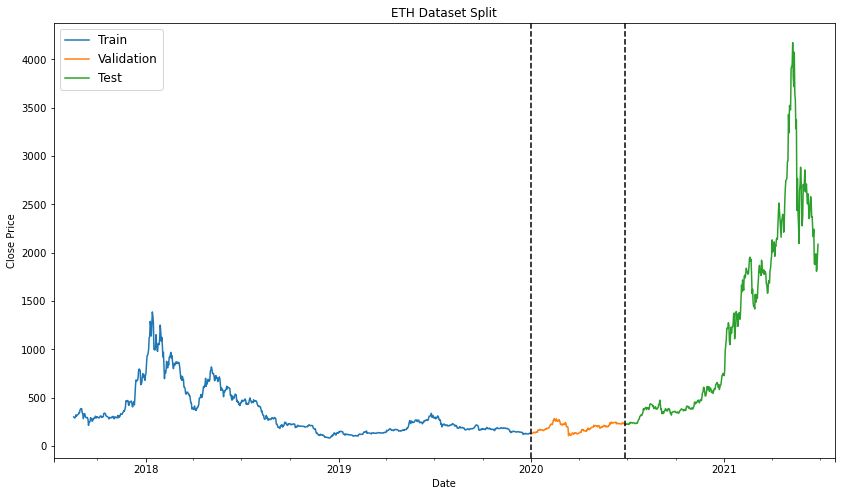

In [48]:
fig, ax = plt.subplots(figsize=(14,8))

ax = trainset['Close'].plot()
valset['Close'].plot(ax=ax)
testset['Close'].plot(ax=ax)
ax.legend(['Train', 'Validation', 'Test'], fontsize = 'large')
ax.set(xlabel="Date",
       ylabel="Close Price",
       title="ETH Dataset Split",
       xlim=["2017-07-10", "2021-07-30"])
plt.axvline(x="2019-12-31", linestyle = '--', color='k')
plt.axvline(x="2020-06-28", linestyle = '--', color='k')

#### The chronological order of values is maintained